In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
import orjson as json
warnings.filterwarnings("ignore")

In [26]:
with open('passed.txt') as f:
    tickers = f.read().splitlines()
tickers.append('^TNX')  # 10 year treasury yield
with open('ticker_capm.json') as f:
    ticker_capm = json.loads(f.read())
MAR = 0.10399819143668938671  # see calc_r.txt

In [27]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    if isinstance(tickers, list):
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
        data.columns = tickers
        data['WYN.L']['2022-06-14'] = 628.0  #TODO: manually fix yahoo data wrong
        data = data[tickers].pct_change().dropna()
        return data
    else:
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:, 'Adj Close']
        data = data.pct_change().dropna()
        return data

returns = download_data_and_calc_returns(tickers)
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
returns = returns.sum(level=0)  # merge 2 days into 1 since different market has diff closing time

[*********************100%***********************]  69 of 69 completed


In [28]:
nasdaq_returns = download_data_and_calc_returns('^IXIC', period='10y')
nasdaq_slpm = rp.RiskFunctions.LPM(nasdaq_returns, MAR=MAR/252, p=2)

[*********************100%***********************]  1 of 1 completed


In [29]:
port = rp.Portfolio(returns=returns, sht=False, lowerret=MAR/252, upperslpm=round((nasdaq_slpm)*(252**(1/2)), 2)/(252**(1/2)))
#round((nasdaq_slpm*0.6)*(252**(1/2)), 2)/(252**(1/2))

In [30]:
method_to_estimate_expected_return = 'ewma1'  # useless, will be overridden with custom returns
method_to_estimate_covariance = 'hist'
port.assets_stats(method_mu=method_to_estimate_expected_return, method_cov=method_to_estimate_covariance, d=0.99)  # lower d means place more emphasis on recent performance, 0 <= d < 1

In [31]:
port.mu['^TNX'] = 0.04/252  # set risk free asset

In [129]:
def custom_returns(col):
    if col.name != '^TNX':
        return pd.Series([ticker_capm[col.name] / (252*100)])
    else:
        return col
port.mu = port.mu.apply(custom_returns, axis=0)

In [130]:
multiplier = [0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1.1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1.75, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1]
port.mu = np.multiply(port.mu,multiplier)

In [128]:
multiplier[port.assetslist.index('CIPLA.BO')] = 1.1
multiplier[port.assetslist.index('NVDA')] = 1.2
multiplier[port.assetslist.index('JPM')] = 1.75
multiplier[port.assetslist.index('WYN.L')] = 0.5
multiplier[port.assetslist.index('TCS.BO')] = 0.5
multiplier[port.assetslist.index('FFH.TO')] = 0.5
multiplier[port.assetslist.index('HDFCBANK.BO')] = 0.5
multiplier[port.assetslist.index('BBSE3.SA')] = 0.5
multiplier[:5] = [0.5 for i in range(5)]
print(multiplier)

[0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1.1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1.75, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1]


In [131]:
port.mu*252

,000333.SZ,000858.SZ,300760.SZ,600007.SS,600519.SS,ABT,AFL,ALL,AMD,AMZN,...,TSLA,UAA,ULTA,UNH,VEEV,WDFC,WMT,WSM,WYN.L,^TNX
0,0.0375,0.042,0.032,0.04,0.038,0.071,0.08,0.079,0.084,0.089,...,0.085,0.103,0.074,0.069,0.068,0.073,0.076,0.082,0.05,0.04


In [132]:
model = 'Classic'  # based on history
risk_measure = 'SLPM'  # Sortino Ratio
obj = 'MinRisk'
risk_free_rate = MAR/252  # MAR converted to daily
w = port.optimization(model=model, rm=risk_measure, obj=obj, rf=risk_free_rate)

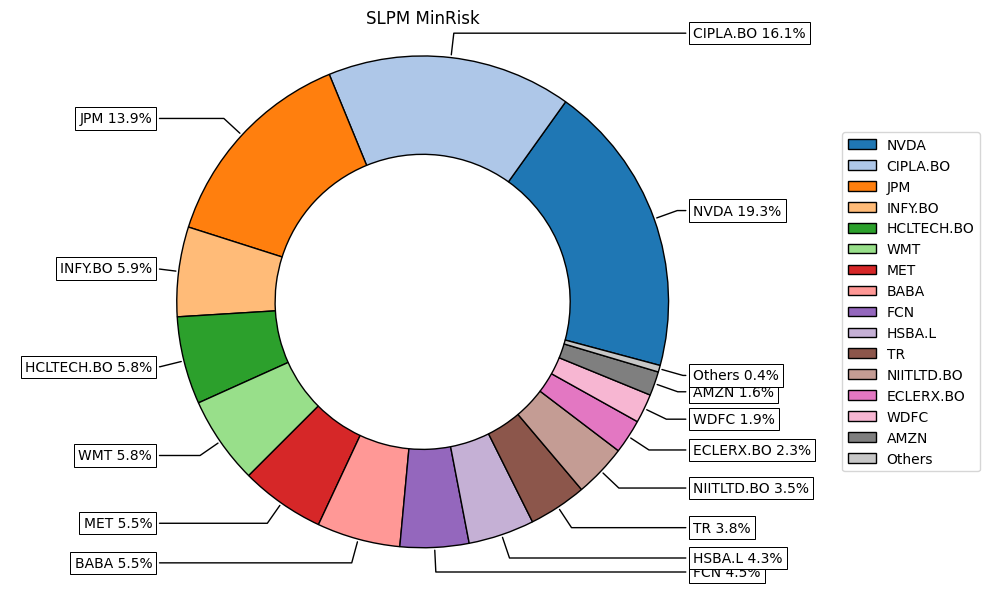

In [133]:
ax = rp.plot_pie(w=w, title=f'{risk_measure} {obj}', others=0.01, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot: title={'center': 'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot: title={'center': 'Portfolio Composition'}>,
       <AxesSubplot: title={'center': 'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

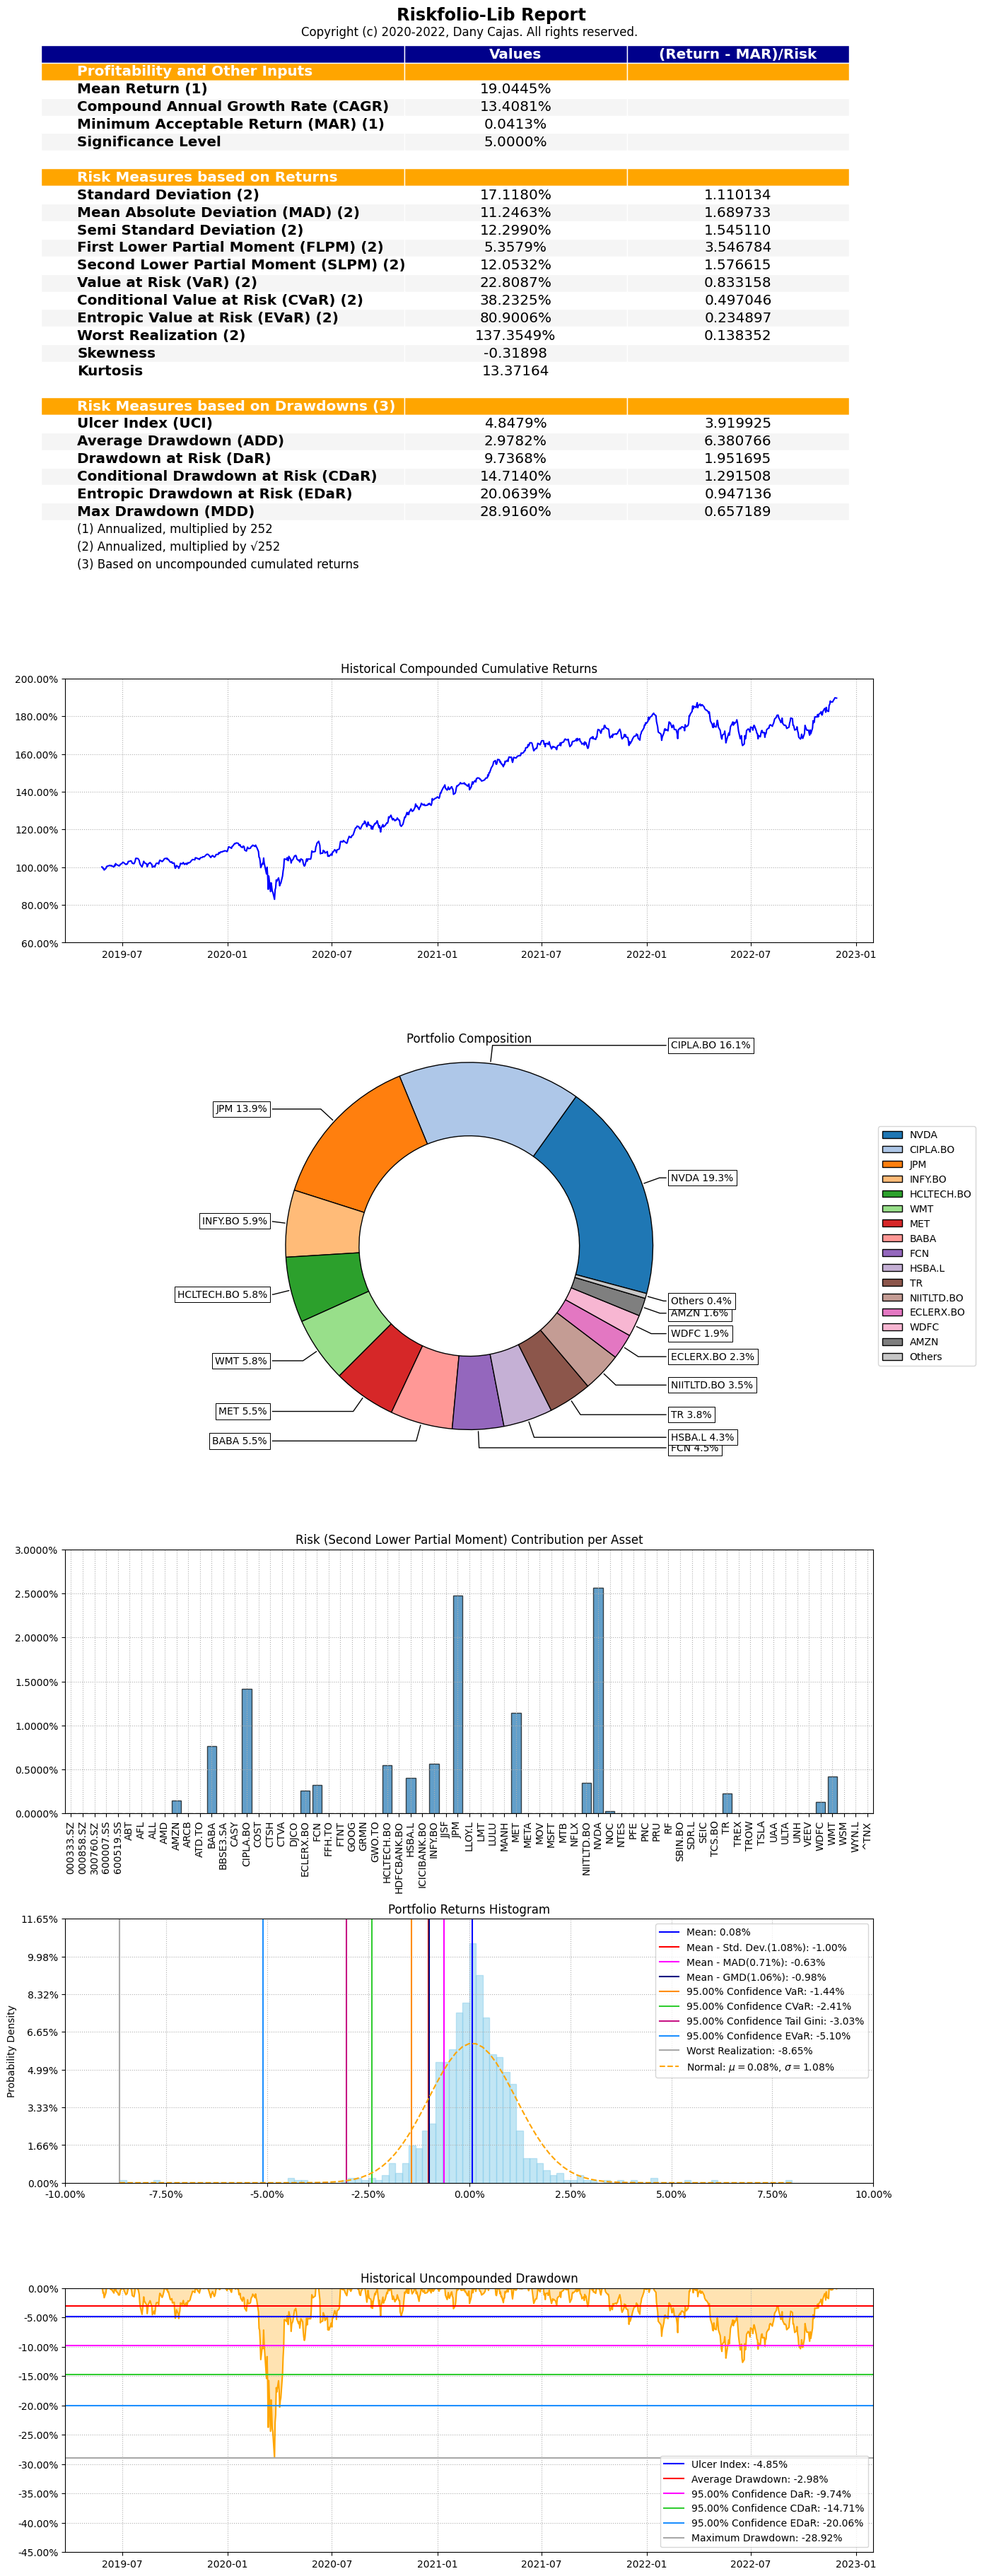

In [134]:
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
rp.Reports.excel_report(returns, w, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='portfolio_report')
rp.Reports.jupyter_report(returns, w, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.01, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)

In [17]:
w.round(8)*100

,weights
000333.SZ,3.744985
000858.SZ,0.000000
300760.SZ,0.000000
600007.SS,2.029429
600519.SS,6.342754
...,...
WDFC,0.000000
WMT,20.119665
WSM,0.000000
WYN.L,0.981832
